In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tqdm.notebook import tqdm
from KMlib.metrics import total_score
from KMlib.plot_metrics import plot_loss,plot_test
from KMlib.processing import pr_scaling,x_scaling,Processer,get_test_data

In [71]:
tf.config.experimental.list_physical_devices('GPU')
tf.keras.backend.clear_session()
tf.random.set_seed(2021)
np.random.seed(2021)

In [30]:
def get_p_model(train,valid, epochs):
    model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True,input_shape = [WINDOW_SIZE, px_train.shape[1]]),
    tf.keras.layers.LSTM(64, return_sequences=False),   
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(30)
        ])
    early_stopping = EarlyStopping('loss', patience=50)
    lr_decay = tf.keras.callbacks.LearningRateScheduler(lambda x:1e-5 * 10**(-x/1000))
    optimizer = tf.keras.optimizers.Adam(lr=1e-5)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)
    history = model.fit(train, epochs=epochs, verbose=1,
                        validation_data=valid,callbacks = [lr_decay,early_stopping])
    return model, history
def get_r_model(train, valid,  epochs):
    model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True,input_shape = [WINDOW_SIZE, px_train.shape[1]]),
    # tf.keras.layers.LSTM(64, return_sequences=True),   
    tf.keras.layers.LSTM(64, return_sequences=False),   
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(30)
        ])
    early_stopping = EarlyStopping('loss', patience=50)
    lr_decay = tf.keras.callbacks.LearningRateScheduler(lambda x:2e-5 * 10**(-x/1000))
    optimizer = tf.keras.optimizers.Adam(lr=2e-5)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)
    history = model.fit(train, epochs=epochs, verbose=1,
                        validation_data=valid,callbacks = [lr_decay,early_stopping])
    return model, history

In [72]:
# change file here
m = 'r_4'
df_rich = pd.read_csv(r'../data/the_rich_r_4.csv',index_col = 0)
df_poor = pd.read_csv(r'../data/the_poor_r_4.csv',index_col = 0)
## get true test value
df = pd.read_csv(r'../data/complete_feature.csv',index_col = 0)
purchase_true = df.loc["2014-08-01":"2014-08-30"].iloc[:, 0]
redeem_true = df.loc["2014-08-01":"2014-08-30"].iloc[:, 1]
df_train = df.loc[:"2014-07-31"]
col = ['total_purchase_amt', 'consume_amt', 'transfer_amt','month', 'day', 'weekday', 'dis_to_nowork',
      'dis_from_nowork', 'dis_to_work',
       'dis_from_work', 'dis_from_holiday', 'dis_to_holiendday',
       'dis_from_holiendday', 'dis_from_endofweek', 'dis_from_purchase_peak',
       'dis_from_purchase_valley', 'user_id',  'weekday_onehot_0', 'weekday_onehot_1', 'weekday_onehot_2',
       'weekday_onehot_3', 'weekday_onehot_4', 'weekday_onehot_5',
       'weekday_onehot_6']  # user id is user count
df_train = df_train[col]

In [73]:
df_poor_train = df_poor.loc[:"2014-07-31",col]
df_rich_train = df_rich.loc[:"2014-07-31",col]
_,_,_,pp_scaler,prc_scaler,prt_scaler = pr_scaling(df_poor_train)
_,_,_,rp_scaler,rrc_scaler,rrt_scaler = pr_scaling(df_rich_train)
px_data,px_scaler =  x_scaling(df_poor_train)
rx_data,rx_scaler =  x_scaling(df_rich_train)

In [74]:
WINDOW_SIZE = 30
BATCH_SIZE = 8
SHUFFLE_BUFFER = 1000 
number_pred = 30
number_shift = 1
input_dimension = 3
L= Processer(WINDOW_SIZE,BATCH_SIZE,SHUFFLE_BUFFER,number_pred,number_shift,input_dimension)
# Train-Valid Split 
px_train,px_valid = L.train_valid_split(px_data)
rx_train,rx_valid = L.train_valid_split(rx_data)

In [76]:
p_col = list(df_poor.columns).index('total_purchase_amt')
c_col = list(df_poor.columns).index('consume_amt')
t_col = list(df_poor.columns).index('transfer_amt')
pp_tensor_train,pp_tensor_valid = L.get_tensor_dataset(px_train,y_col = p_col)
prc_tensor_train,prc_tensor_valid = L.get_tensor_dataset(px_train,y_col = c_col)
prt_tensor_train,prt_tensor_valid = L.get_tensor_dataset(px_train,y_col = t_col)
rp_tensor_train,rp_tensor_valid = L.get_tensor_dataset(rx_train,y_col = p_col)
rrc_tensor_train,rrc_tensor_valid = L.get_tensor_dataset(rx_train,y_col = c_col)
rrt_tensor_train,rrt_tensor_valid = L.get_tensor_dataset(rx_train,y_col = t_col)


## Model developing

Epoch 1/500
24/24 [==============================] - 3s 113ms/step - loss: 0.0423 - val_loss: 0.1763 - lr: 1.0000e-05
Epoch 2/500
24/24 [==============================] - 1s 57ms/step - loss: 0.0412 - val_loss: 0.1745 - lr: 9.9770e-06
Epoch 3/500
24/24 [==============================] - 1s 56ms/step - loss: 0.0403 - val_loss: 0.1730 - lr: 9.9541e-06
Epoch 4/500
24/24 [==============================] - 1s 61ms/step - loss: 0.0396 - val_loss: 0.1716 - lr: 9.9312e-06
Epoch 5/500
24/24 [==============================] - 1s 56ms/step - loss: 0.0390 - val_loss: 0.1707 - lr: 9.9083e-06
Epoch 6/500
24/24 [==============================] - 1s 55ms/step - loss: 0.0385 - val_loss: 0.1697 - lr: 9.8855e-06
Epoch 7/500
24/24 [==============================] - 1s 56ms/step - loss: 0.0381 - val_loss: 0.1687 - lr: 9.8628e-06
Epoch 8/500
24/24 [==============================] - 1s 56ms/step - loss: 0.0377 - val_loss: 0.1677 - lr: 9.8401e-06
Epoch 9/500
24/24 [==============================] - 1s 56ms/st

24/24 [==============================] - 1s 56ms/step - loss: 0.0115 - val_loss: 0.0497 - lr: 7.2778e-06
Epoch 140/500
24/24 [==============================] - 1s 56ms/step - loss: 0.0114 - val_loss: 0.0494 - lr: 7.2611e-06
Epoch 141/500
24/24 [==============================] - 1s 56ms/step - loss: 0.0113 - val_loss: 0.0490 - lr: 7.2444e-06
Epoch 142/500
24/24 [==============================] - 1s 55ms/step - loss: 0.0113 - val_loss: 0.0487 - lr: 7.2277e-06
Epoch 143/500
24/24 [==============================] - 1s 55ms/step - loss: 0.0112 - val_loss: 0.0483 - lr: 7.2111e-06
Epoch 144/500
24/24 [==============================] - 1s 56ms/step - loss: 0.0111 - val_loss: 0.0480 - lr: 7.1945e-06
Epoch 145/500
24/24 [==============================] - 1s 55ms/step - loss: 0.0110 - val_loss: 0.0476 - lr: 7.1779e-06
Epoch 146/500
24/24 [==============================] - 1s 55ms/step - loss: 0.0110 - val_loss: 0.0472 - lr: 7.1614e-06
Epoch 147/500
24/24 [==============================] - 1s 55ms

Epoch 208/500
24/24 [==============================] - 1s 54ms/step - loss: 0.0076 - val_loss: 0.0312 - lr: 6.2087e-06
Epoch 209/500
24/24 [==============================] - 1s 54ms/step - loss: 0.0075 - val_loss: 0.0311 - lr: 6.1944e-06
Epoch 210/500
24/24 [==============================] - 1s 55ms/step - loss: 0.0075 - val_loss: 0.0307 - lr: 6.1802e-06
Epoch 211/500
24/24 [==============================] - 1s 55ms/step - loss: 0.0075 - val_loss: 0.0306 - lr: 6.1659e-06
Epoch 212/500
24/24 [==============================] - 1s 55ms/step - loss: 0.0074 - val_loss: 0.0304 - lr: 6.1518e-06
Epoch 213/500
24/24 [==============================] - 1s 55ms/step - loss: 0.0074 - val_loss: 0.0303 - lr: 6.1376e-06
Epoch 214/500
24/24 [==============================] - 1s 54ms/step - loss: 0.0074 - val_loss: 0.0301 - lr: 6.1235e-06
Epoch 215/500
24/24 [==============================] - 1s 55ms/step - loss: 0.0073 - val_loss: 0.0299 - lr: 6.1094e-06
Epoch 216/500
24/24 [===========================

Epoch 277/500
24/24 [==============================] - 1s 56ms/step - loss: 0.0059 - val_loss: 0.0222 - lr: 5.2966e-06
Epoch 278/500
24/24 [==============================] - 1s 56ms/step - loss: 0.0059 - val_loss: 0.0221 - lr: 5.2845e-06
Epoch 279/500
24/24 [==============================] - 1s 56ms/step - loss: 0.0059 - val_loss: 0.0221 - lr: 5.2723e-06
Epoch 280/500
24/24 [==============================] - 1s 55ms/step - loss: 0.0059 - val_loss: 0.0219 - lr: 5.2602e-06
Epoch 281/500
24/24 [==============================] - 1s 55ms/step - loss: 0.0058 - val_loss: 0.0218 - lr: 5.2481e-06
Epoch 282/500
24/24 [==============================] - 1s 58ms/step - loss: 0.0058 - val_loss: 0.0217 - lr: 5.2360e-06
Epoch 283/500
24/24 [==============================] - 1s 60ms/step - loss: 0.0058 - val_loss: 0.0216 - lr: 5.2240e-06
Epoch 284/500
24/24 [==============================] - 1s 61ms/step - loss: 0.0058 - val_loss: 0.0216 - lr: 5.2119e-06
Epoch 285/500
24/24 [===========================

Epoch 346/500
24/24 [==============================] - 1s 56ms/step - loss: 0.0053 - val_loss: 0.0182 - lr: 4.5186e-06
Epoch 347/500
24/24 [==============================] - 1s 61ms/step - loss: 0.0053 - val_loss: 0.0181 - lr: 4.5082e-06
Epoch 348/500
24/24 [==============================] - 1s 55ms/step - loss: 0.0053 - val_loss: 0.0181 - lr: 4.4978e-06
Epoch 349/500
24/24 [==============================] - 1s 56ms/step - loss: 0.0053 - val_loss: 0.0181 - lr: 4.4875e-06
Epoch 350/500
24/24 [==============================] - 1s 53ms/step - loss: 0.0053 - val_loss: 0.0180 - lr: 4.4771e-06
Epoch 351/500
24/24 [==============================] - 1s 54ms/step - loss: 0.0053 - val_loss: 0.0180 - lr: 4.4668e-06
Epoch 352/500
24/24 [==============================] - 1s 54ms/step - loss: 0.0053 - val_loss: 0.0180 - lr: 4.4566e-06
Epoch 353/500
24/24 [==============================] - 1s 54ms/step - loss: 0.0053 - val_loss: 0.0179 - lr: 4.4463e-06
Epoch 354/500
24/24 [===========================

Epoch 415/500
24/24 [==============================] - 1s 48ms/step - loss: 0.0051 - val_loss: 0.0162 - lr: 3.8548e-06
Epoch 416/500
24/24 [==============================] - 1s 48ms/step - loss: 0.0051 - val_loss: 0.0161 - lr: 3.8459e-06
Epoch 417/500
24/24 [==============================] - 1s 48ms/step - loss: 0.0051 - val_loss: 0.0161 - lr: 3.8371e-06
Epoch 418/500
24/24 [==============================] - 1s 48ms/step - loss: 0.0051 - val_loss: 0.0161 - lr: 3.8282e-06
Epoch 419/500
24/24 [==============================] - 1s 48ms/step - loss: 0.0051 - val_loss: 0.0161 - lr: 3.8194e-06
Epoch 420/500
24/24 [==============================] - 1s 49ms/step - loss: 0.0051 - val_loss: 0.0161 - lr: 3.8107e-06
Epoch 421/500
24/24 [==============================] - 1s 47ms/step - loss: 0.0051 - val_loss: 0.0160 - lr: 3.8019e-06
Epoch 422/500
24/24 [==============================] - 1s 48ms/step - loss: 0.0051 - val_loss: 0.0161 - lr: 3.7931e-06
Epoch 423/500
24/24 [===========================

Epoch 484/500
24/24 [==============================] - 1s 58ms/step - loss: 0.0050 - val_loss: 0.0152 - lr: 3.2885e-06
Epoch 485/500
24/24 [==============================] - 1s 59ms/step - loss: 0.0050 - val_loss: 0.0151 - lr: 3.2810e-06
Epoch 486/500
24/24 [==============================] - 1s 60ms/step - loss: 0.0050 - val_loss: 0.0152 - lr: 3.2734e-06
Epoch 487/500
24/24 [==============================] - 1s 59ms/step - loss: 0.0050 - val_loss: 0.0151 - lr: 3.2659e-06
Epoch 488/500
24/24 [==============================] - 1s 57ms/step - loss: 0.0050 - val_loss: 0.0152 - lr: 3.2584e-06
Epoch 489/500
24/24 [==============================] - 2s 74ms/step - loss: 0.0050 - val_loss: 0.0152 - lr: 3.2509e-06
Epoch 490/500
24/24 [==============================] - 2s 77ms/step - loss: 0.0050 - val_loss: 0.0151 - lr: 3.2434e-06
Epoch 491/500
24/24 [==============================] - 2s 71ms/step - loss: 0.0050 - val_loss: 0.0151 - lr: 3.2359e-06
Epoch 492/500
24/24 [===========================

24/24 [==============================] - 1s 57ms/step - loss: 0.0114 - val_loss: 0.0227 - lr: 7.5683e-06
Epoch 123/500
24/24 [==============================] - 1s 57ms/step - loss: 0.0114 - val_loss: 0.0226 - lr: 7.5509e-06
Epoch 124/500
24/24 [==============================] - 1s 59ms/step - loss: 0.0113 - val_loss: 0.0225 - lr: 7.5336e-06
Epoch 125/500
24/24 [==============================] - 1s 57ms/step - loss: 0.0113 - val_loss: 0.0224 - lr: 7.5162e-06
Epoch 126/500
24/24 [==============================] - 2s 64ms/step - loss: 0.0113 - val_loss: 0.0224 - lr: 7.4989e-06
Epoch 127/500
24/24 [==============================] - 2s 76ms/step - loss: 0.0112 - val_loss: 0.0223 - lr: 7.4817e-06
Epoch 128/500
24/24 [==============================] - 2s 88ms/step - loss: 0.0112 - val_loss: 0.0221 - lr: 7.4645e-06
Epoch 129/500
24/24 [==============================] - 1s 62ms/step - loss: 0.0112 - val_loss: 0.0221 - lr: 7.4473e-06
Epoch 130/500
24/24 [==============================] - 1s 55ms

Epoch 191/500
24/24 [==============================] - 2s 64ms/step - loss: 0.0098 - val_loss: 0.0176 - lr: 6.4565e-06
Epoch 192/500
24/24 [==============================] - 1s 60ms/step - loss: 0.0098 - val_loss: 0.0175 - lr: 6.4417e-06
Epoch 193/500
24/24 [==============================] - 1s 59ms/step - loss: 0.0098 - val_loss: 0.0175 - lr: 6.4269e-06
Epoch 194/500
24/24 [==============================] - 1s 62ms/step - loss: 0.0098 - val_loss: 0.0175 - lr: 6.4121e-06
Epoch 195/500
24/24 [==============================] - 2s 81ms/step - loss: 0.0097 - val_loss: 0.0174 - lr: 6.3973e-06
Epoch 196/500
24/24 [==============================] - 1s 59ms/step - loss: 0.0097 - val_loss: 0.0173 - lr: 6.3826e-06
Epoch 197/500
24/24 [==============================] - 2s 65ms/step - loss: 0.0097 - val_loss: 0.0173 - lr: 6.3680e-06
Epoch 198/500
24/24 [==============================] - 1s 61ms/step - loss: 0.0097 - val_loss: 0.0172 - lr: 6.3533e-06
Epoch 199/500
24/24 [===========================

Epoch 328/500
24/24 [==============================] - 2s 74ms/step - loss: 0.0086 - val_loss: 0.0132 - lr: 4.7098e-06
Epoch 329/500
24/24 [==============================] - 2s 72ms/step - loss: 0.0086 - val_loss: 0.0131 - lr: 4.6989e-06
Epoch 330/500
24/24 [==============================] - 2s 68ms/step - loss: 0.0086 - val_loss: 0.0131 - lr: 4.6881e-06
Epoch 331/500
24/24 [==============================] - 2s 70ms/step - loss: 0.0086 - val_loss: 0.0131 - lr: 4.6774e-06
Epoch 332/500
24/24 [==============================] - 2s 74ms/step - loss: 0.0086 - val_loss: 0.0131 - lr: 4.6666e-06
Epoch 333/500
24/24 [==============================] - 2s 76ms/step - loss: 0.0086 - val_loss: 0.0131 - lr: 4.6559e-06
Epoch 334/500
24/24 [==============================] - 2s 73ms/step - loss: 0.0086 - val_loss: 0.0131 - lr: 4.6452e-06
Epoch 335/500
24/24 [==============================] - 2s 70ms/step - loss: 0.0086 - val_loss: 0.0130 - lr: 4.6345e-06
Epoch 336/500
24/24 [===========================

Epoch 397/500
24/24 [==============================] - 2s 73ms/step - loss: 0.0084 - val_loss: 0.0127 - lr: 4.0179e-06
Epoch 398/500
24/24 [==============================] - 2s 72ms/step - loss: 0.0084 - val_loss: 0.0126 - lr: 4.0087e-06
Epoch 399/500
24/24 [==============================] - 2s 72ms/step - loss: 0.0084 - val_loss: 0.0126 - lr: 3.9994e-06
Epoch 400/500
24/24 [==============================] - 2s 72ms/step - loss: 0.0083 - val_loss: 0.0126 - lr: 3.9902e-06
Epoch 401/500
24/24 [==============================] - 2s 71ms/step - loss: 0.0083 - val_loss: 0.0127 - lr: 3.9811e-06
Epoch 402/500
24/24 [==============================] - 2s 75ms/step - loss: 0.0083 - val_loss: 0.0126 - lr: 3.9719e-06
Epoch 403/500
24/24 [==============================] - 2s 81ms/step - loss: 0.0083 - val_loss: 0.0126 - lr: 3.9628e-06
Epoch 404/500
24/24 [==============================] - 2s 74ms/step - loss: 0.0083 - val_loss: 0.0127 - lr: 3.9537e-06
Epoch 405/500
24/24 [===========================

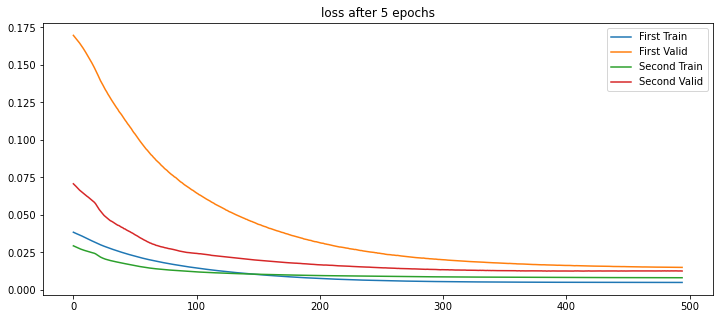

In [94]:
tf.keras.backend.clear_session()
tf.random.set_seed(2021)
np.random.seed(2021)
epochs = 500
pp_model,pp_history =get_p_model(pp_tensor_train ,pp_tensor_valid,epochs = epochs)
tf.keras.backend.clear_session()
rp_model,rp_history =get_p_model(rp_tensor_train ,rp_tensor_valid,epochs = epochs)
plot_loss(pp_history, rp_history)

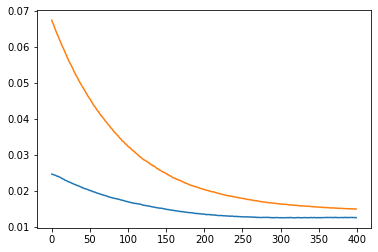

In [98]:
plt.plot(rp_history.history['val_loss'][100:])
plt.plot(pp_history.history['val_loss'][100:])

Epoch 1/400
24/24 [==============================] - 3s 112ms/step - loss: 0.2507 - val_loss: 0.0555 - lr: 2.0000e-05
Epoch 2/400
24/24 [==============================] - 1s 35ms/step - loss: 0.2440 - val_loss: 0.0525 - lr: 1.9954e-05
Epoch 3/400
24/24 [==============================] - 1s 38ms/step - loss: 0.2372 - val_loss: 0.0492 - lr: 1.9908e-05
Epoch 4/400
24/24 [==============================] - 1s 45ms/step - loss: 0.2302 - val_loss: 0.0460 - lr: 1.9862e-05
Epoch 5/400
24/24 [==============================] - 1s 39ms/step - loss: 0.2232 - val_loss: 0.0432 - lr: 1.9817e-05
Epoch 6/400
24/24 [==============================] - 1s 37ms/step - loss: 0.2154 - val_loss: 0.0404 - lr: 1.9771e-05
Epoch 7/400
24/24 [==============================] - 1s 46ms/step - loss: 0.2049 - val_loss: 0.0372 - lr: 1.9726e-05
Epoch 8/400
24/24 [==============================] - 1s 60ms/step - loss: 0.1933 - val_loss: 0.0351 - lr: 1.9680e-05
Epoch 9/400
24/24 [==============================] - 2s 63ms/st

24/24 [==============================] - 1s 50ms/step - loss: 0.0092 - val_loss: 0.0435 - lr: 1.4556e-05
Epoch 140/400
24/24 [==============================] - 1s 46ms/step - loss: 0.0091 - val_loss: 0.0434 - lr: 1.4522e-05
Epoch 141/400
24/24 [==============================] - 1s 40ms/step - loss: 0.0091 - val_loss: 0.0433 - lr: 1.4489e-05
Epoch 142/400
24/24 [==============================] - 1s 43ms/step - loss: 0.0090 - val_loss: 0.0433 - lr: 1.4455e-05
Epoch 143/400
24/24 [==============================] - 1s 39ms/step - loss: 0.0092 - val_loss: 0.0432 - lr: 1.4422e-05
Epoch 144/400
24/24 [==============================] - 1s 38ms/step - loss: 0.0091 - val_loss: 0.0432 - lr: 1.4389e-05
Epoch 145/400
24/24 [==============================] - 1s 40ms/step - loss: 0.0092 - val_loss: 0.0431 - lr: 1.4356e-05
Epoch 146/400
24/24 [==============================] - 1s 41ms/step - loss: 0.0089 - val_loss: 0.0431 - lr: 1.4323e-05
Epoch 147/400
24/24 [==============================] - 1s 38ms

Epoch 208/400
24/24 [==============================] - 1s 36ms/step - loss: 0.0071 - val_loss: 0.0404 - lr: 1.2417e-05
Epoch 209/400
24/24 [==============================] - 1s 36ms/step - loss: 0.0070 - val_loss: 0.0404 - lr: 1.2389e-05
Epoch 210/400
24/24 [==============================] - 1s 37ms/step - loss: 0.0070 - val_loss: 0.0404 - lr: 1.2360e-05
Epoch 211/400
24/24 [==============================] - 1s 35ms/step - loss: 0.0069 - val_loss: 0.0404 - lr: 1.2332e-05
Epoch 212/400
24/24 [==============================] - 1s 36ms/step - loss: 0.0070 - val_loss: 0.0403 - lr: 1.2304e-05
Epoch 213/400
24/24 [==============================] - 1s 36ms/step - loss: 0.0069 - val_loss: 0.0403 - lr: 1.2275e-05
Epoch 214/400
24/24 [==============================] - 1s 38ms/step - loss: 0.0069 - val_loss: 0.0402 - lr: 1.2247e-05
Epoch 215/400
24/24 [==============================] - 1s 37ms/step - loss: 0.0069 - val_loss: 0.0402 - lr: 1.2219e-05
Epoch 216/400
24/24 [===========================

Epoch 277/400
24/24 [==============================] - 1s 39ms/step - loss: 0.0058 - val_loss: 0.0384 - lr: 1.0593e-05
Epoch 278/400
24/24 [==============================] - 1s 38ms/step - loss: 0.0057 - val_loss: 0.0384 - lr: 1.0569e-05
Epoch 279/400
24/24 [==============================] - 1s 39ms/step - loss: 0.0056 - val_loss: 0.0383 - lr: 1.0545e-05
Epoch 280/400
24/24 [==============================] - 1s 38ms/step - loss: 0.0057 - val_loss: 0.0383 - lr: 1.0520e-05
Epoch 281/400
24/24 [==============================] - 1s 40ms/step - loss: 0.0056 - val_loss: 0.0383 - lr: 1.0496e-05
Epoch 282/400
24/24 [==============================] - 1s 39ms/step - loss: 0.0057 - val_loss: 0.0383 - lr: 1.0472e-05
Epoch 283/400
24/24 [==============================] - 1s 40ms/step - loss: 0.0056 - val_loss: 0.0383 - lr: 1.0448e-05
Epoch 284/400
24/24 [==============================] - 1s 38ms/step - loss: 0.0056 - val_loss: 0.0382 - lr: 1.0424e-05
Epoch 285/400
24/24 [===========================

Epoch 346/400
24/24 [==============================] - 1s 39ms/step - loss: 0.0048 - val_loss: 0.0368 - lr: 9.0371e-06
Epoch 347/400
24/24 [==============================] - 1s 38ms/step - loss: 0.0048 - val_loss: 0.0368 - lr: 9.0163e-06
Epoch 348/400
24/24 [==============================] - 1s 40ms/step - loss: 0.0048 - val_loss: 0.0368 - lr: 8.9956e-06
Epoch 349/400
24/24 [==============================] - 1s 40ms/step - loss: 0.0048 - val_loss: 0.0367 - lr: 8.9749e-06
Epoch 350/400
24/24 [==============================] - 1s 38ms/step - loss: 0.0048 - val_loss: 0.0367 - lr: 8.9543e-06
Epoch 351/400
24/24 [==============================] - 1s 37ms/step - loss: 0.0048 - val_loss: 0.0367 - lr: 8.9337e-06
Epoch 352/400
24/24 [==============================] - 1s 37ms/step - loss: 0.0048 - val_loss: 0.0367 - lr: 8.9131e-06
Epoch 353/400
24/24 [==============================] - 1s 36ms/step - loss: 0.0048 - val_loss: 0.0367 - lr: 8.8926e-06
Epoch 354/400
24/24 [===========================

Epoch 15/400
24/24 [==============================] - 1s 43ms/step - loss: 0.0968 - val_loss: 0.0844 - lr: 1.9366e-05
Epoch 16/400
24/24 [==============================] - 1s 43ms/step - loss: 0.0937 - val_loss: 0.0809 - lr: 1.9321e-05
Epoch 17/400
24/24 [==============================] - 1s 40ms/step - loss: 0.0910 - val_loss: 0.0781 - lr: 1.9277e-05
Epoch 18/400
24/24 [==============================] - 1s 55ms/step - loss: 0.0885 - val_loss: 0.0748 - lr: 1.9232e-05
Epoch 19/400
24/24 [==============================] - 1s 46ms/step - loss: 0.0864 - val_loss: 0.0724 - lr: 1.9188e-05
Epoch 20/400
24/24 [==============================] - 1s 41ms/step - loss: 0.0844 - val_loss: 0.0709 - lr: 1.9144e-05
Epoch 21/400
24/24 [==============================] - 1s 38ms/step - loss: 0.0828 - val_loss: 0.0691 - lr: 1.9100e-05
Epoch 22/400
24/24 [==============================] - 1s 40ms/step - loss: 0.0810 - val_loss: 0.0669 - lr: 1.9056e-05
Epoch 23/400
24/24 [==============================] - 1s

24/24 [==============================] - 1s 38ms/step - loss: 0.0254 - val_loss: 0.0277 - lr: 1.4094e-05
Epoch 154/400
24/24 [==============================] - 1s 38ms/step - loss: 0.0252 - val_loss: 0.0274 - lr: 1.4061e-05
Epoch 155/400
24/24 [==============================] - 1s 42ms/step - loss: 0.0251 - val_loss: 0.0271 - lr: 1.4029e-05
Epoch 156/400
24/24 [==============================] - 1s 40ms/step - loss: 0.0249 - val_loss: 0.0270 - lr: 1.3997e-05
Epoch 157/400
24/24 [==============================] - 1s 39ms/step - loss: 0.0248 - val_loss: 0.0267 - lr: 1.3965e-05
Epoch 158/400
24/24 [==============================] - 1s 38ms/step - loss: 0.0246 - val_loss: 0.0268 - lr: 1.3933e-05
Epoch 159/400
24/24 [==============================] - 1s 38ms/step - loss: 0.0245 - val_loss: 0.0266 - lr: 1.3900e-05
Epoch 160/400
24/24 [==============================] - 1s 38ms/step - loss: 0.0243 - val_loss: 0.0263 - lr: 1.3869e-05
Epoch 161/400
24/24 [==============================] - 1s 38ms

Epoch 222/400
24/24 [==============================] - 1s 38ms/step - loss: 0.0181 - val_loss: 0.0217 - lr: 1.2023e-05
Epoch 223/400
24/24 [==============================] - 1s 38ms/step - loss: 0.0180 - val_loss: 0.0217 - lr: 1.1996e-05
Epoch 224/400
24/24 [==============================] - 1s 39ms/step - loss: 0.0179 - val_loss: 0.0217 - lr: 1.1968e-05
Epoch 225/400
24/24 [==============================] - 1s 39ms/step - loss: 0.0179 - val_loss: 0.0217 - lr: 1.1941e-05
Epoch 226/400
24/24 [==============================] - 1s 38ms/step - loss: 0.0178 - val_loss: 0.0216 - lr: 1.1913e-05
Epoch 227/400
24/24 [==============================] - 1s 38ms/step - loss: 0.0177 - val_loss: 0.0215 - lr: 1.1886e-05
Epoch 228/400
24/24 [==============================] - 1s 40ms/step - loss: 0.0177 - val_loss: 0.0215 - lr: 1.1859e-05
Epoch 229/400
24/24 [==============================] - 1s 38ms/step - loss: 0.0176 - val_loss: 0.0215 - lr: 1.1831e-05
Epoch 230/400
24/24 [===========================

Epoch 291/400
24/24 [==============================] - 1s 35ms/step - loss: 0.0143 - val_loss: 0.0206 - lr: 1.0257e-05
Epoch 292/400
24/24 [==============================] - 1s 37ms/step - loss: 0.0143 - val_loss: 0.0204 - lr: 1.0234e-05
Epoch 293/400
24/24 [==============================] - 1s 35ms/step - loss: 0.0143 - val_loss: 0.0204 - lr: 1.0210e-05
Epoch 294/400
24/24 [==============================] - 1s 33ms/step - loss: 0.0142 - val_loss: 0.0204 - lr: 1.0187e-05
Epoch 295/400
24/24 [==============================] - 1s 37ms/step - loss: 0.0142 - val_loss: 0.0202 - lr: 1.0163e-05
Epoch 296/400
24/24 [==============================] - 1s 38ms/step - loss: 0.0141 - val_loss: 0.0205 - lr: 1.0140e-05
Epoch 297/400
24/24 [==============================] - 1s 35ms/step - loss: 0.0141 - val_loss: 0.0203 - lr: 1.0116e-05
Epoch 298/400
24/24 [==============================] - 1s 38ms/step - loss: 0.0141 - val_loss: 0.0203 - lr: 1.0093e-05
Epoch 299/400
24/24 [===========================

Epoch 360/400
24/24 [==============================] - 1s 34ms/step - loss: 0.0123 - val_loss: 0.0195 - lr: 8.7504e-06
Epoch 361/400
24/24 [==============================] - 1s 37ms/step - loss: 0.0123 - val_loss: 0.0195 - lr: 8.7303e-06
Epoch 362/400
24/24 [==============================] - 1s 42ms/step - loss: 0.0123 - val_loss: 0.0193 - lr: 8.7102e-06
Epoch 363/400
24/24 [==============================] - 1s 40ms/step - loss: 0.0123 - val_loss: 0.0194 - lr: 8.6902e-06
Epoch 364/400
24/24 [==============================] - 1s 40ms/step - loss: 0.0123 - val_loss: 0.0193 - lr: 8.6702e-06
Epoch 365/400
24/24 [==============================] - 1s 41ms/step - loss: 0.0122 - val_loss: 0.0195 - lr: 8.6503e-06
Epoch 366/400
24/24 [==============================] - 1s 38ms/step - loss: 0.0122 - val_loss: 0.0194 - lr: 8.6304e-06
Epoch 367/400
24/24 [==============================] - 1s 41ms/step - loss: 0.0122 - val_loss: 0.0193 - lr: 8.6105e-06
Epoch 368/400
24/24 [===========================

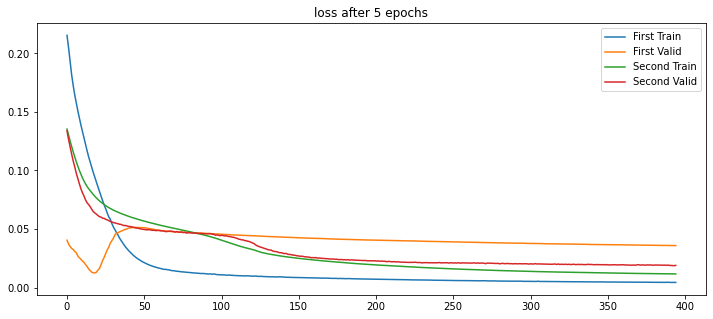

In [85]:
tf.keras.backend.clear_session()
epochs = 400
prc_model,prc_history =get_r_model(prc_tensor_train,prc_tensor_valid,epochs = epochs)
tf.keras.backend.clear_session()
prt_model,prt_history =get_r_model(prt_tensor_train,prt_tensor_valid,epochs = epochs)
plot_loss(prc_history,prt_history)

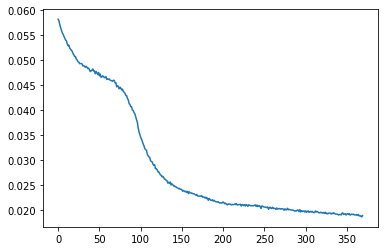

In [86]:
plt.plot(prt_history.history['val_loss'][30:])

Epoch 1/500
24/24 [==============================] - 3s 107ms/step - loss: 0.2521 - val_loss: 0.0572 - lr: 2.0000e-05
Epoch 2/500
24/24 [==============================] - 1s 52ms/step - loss: 0.2485 - val_loss: 0.0558 - lr: 1.9954e-05
Epoch 3/500
24/24 [==============================] - 1s 56ms/step - loss: 0.2448 - val_loss: 0.0543 - lr: 1.9908e-05
Epoch 4/500
24/24 [==============================] - 1s 57ms/step - loss: 0.2406 - val_loss: 0.0525 - lr: 1.9862e-05
Epoch 5/500
24/24 [==============================] - 1s 52ms/step - loss: 0.2360 - val_loss: 0.0507 - lr: 1.9817e-05
Epoch 6/500
24/24 [==============================] - 1s 52ms/step - loss: 0.2311 - val_loss: 0.0490 - lr: 1.9771e-05
Epoch 7/500
24/24 [==============================] - 1s 52ms/step - loss: 0.2257 - val_loss: 0.0477 - lr: 1.9726e-05
Epoch 8/500
24/24 [==============================] - 1s 53ms/step - loss: 0.2206 - val_loss: 0.0467 - lr: 1.9680e-05
Epoch 9/500
24/24 [==============================] - 1s 52ms/st

24/24 [==============================] - 1s 52ms/step - loss: 0.0164 - val_loss: 0.0427 - lr: 1.4556e-05
Epoch 140/500
24/24 [==============================] - ETA: 0s - loss: 0.015 - 1s 53ms/step - loss: 0.0161 - val_loss: 0.0427 - lr: 1.4522e-05
Epoch 141/500
24/24 [==============================] - 1s 53ms/step - loss: 0.0160 - val_loss: 0.0427 - lr: 1.4489e-05
Epoch 142/500
24/24 [==============================] - 1s 52ms/step - loss: 0.0157 - val_loss: 0.0427 - lr: 1.4455e-05
Epoch 143/500
24/24 [==============================] - 1s 53ms/step - loss: 0.0155 - val_loss: 0.0425 - lr: 1.4422e-05
Epoch 144/500
24/24 [==============================] - 1s 52ms/step - loss: 0.0153 - val_loss: 0.0425 - lr: 1.4389e-05
Epoch 145/500
24/24 [==============================] - 1s 52ms/step - loss: 0.0151 - val_loss: 0.0425 - lr: 1.4356e-05
Epoch 146/500
24/24 [==============================] - 1s 52ms/step - loss: 0.0148 - val_loss: 0.0425 - lr: 1.4323e-05
Epoch 147/500
24/24 [=================

Epoch 208/500
24/24 [==============================] - 1s 53ms/step - loss: 0.0087 - val_loss: 0.0407 - lr: 1.2417e-05
Epoch 209/500
24/24 [==============================] - 1s 53ms/step - loss: 0.0086 - val_loss: 0.0407 - lr: 1.2389e-05
Epoch 210/500
24/24 [==============================] - 1s 53ms/step - loss: 0.0086 - val_loss: 0.0407 - lr: 1.2360e-05
Epoch 211/500
24/24 [==============================] - 1s 52ms/step - loss: 0.0086 - val_loss: 0.0406 - lr: 1.2332e-05
Epoch 212/500
24/24 [==============================] - 1s 53ms/step - loss: 0.0085 - val_loss: 0.0406 - lr: 1.2304e-05
Epoch 213/500
24/24 [==============================] - 1s 53ms/step - loss: 0.0086 - val_loss: 0.0406 - lr: 1.2275e-05
Epoch 214/500
24/24 [==============================] - 1s 53ms/step - loss: 0.0085 - val_loss: 0.0405 - lr: 1.2247e-05
Epoch 215/500
24/24 [==============================] - 1s 53ms/step - loss: 0.0084 - val_loss: 0.0405 - lr: 1.2219e-05
Epoch 216/500
24/24 [===========================

Epoch 277/500
24/24 [==============================] - 1s 53ms/step - loss: 0.0069 - val_loss: 0.0387 - lr: 1.0593e-05
Epoch 278/500
24/24 [==============================] - 1s 52ms/step - loss: 0.0069 - val_loss: 0.0388 - lr: 1.0569e-05
Epoch 279/500
24/24 [==============================] - 1s 54ms/step - loss: 0.0069 - val_loss: 0.0386 - lr: 1.0545e-05
Epoch 280/500
24/24 [==============================] - 1s 53ms/step - loss: 0.0069 - val_loss: 0.0386 - lr: 1.0520e-05
Epoch 281/500
24/24 [==============================] - 1s 53ms/step - loss: 0.0068 - val_loss: 0.0386 - lr: 1.0496e-05
Epoch 282/500
24/24 [==============================] - 1s 53ms/step - loss: 0.0069 - val_loss: 0.0385 - lr: 1.0472e-05
Epoch 283/500
24/24 [==============================] - 1s 53ms/step - loss: 0.0068 - val_loss: 0.0385 - lr: 1.0448e-05
Epoch 284/500
24/24 [==============================] - 1s 53ms/step - loss: 0.0068 - val_loss: 0.0384 - lr: 1.0424e-05
Epoch 285/500
24/24 [===========================

Epoch 414/500
24/24 [==============================] - 1s 53ms/step - loss: 0.0052 - val_loss: 0.0359 - lr: 7.7273e-06
Epoch 415/500
24/24 [==============================] - 1s 52ms/step - loss: 0.0051 - val_loss: 0.0358 - lr: 7.7096e-06
Epoch 416/500
24/24 [==============================] - 1s 53ms/step - loss: 0.0051 - val_loss: 0.0358 - lr: 7.6918e-06
Epoch 417/500
24/24 [==============================] - 1s 53ms/step - loss: 0.0052 - val_loss: 0.0358 - lr: 7.6741e-06
Epoch 418/500
24/24 [==============================] - 1s 53ms/step - loss: 0.0052 - val_loss: 0.0357 - lr: 7.6565e-06
Epoch 419/500
24/24 [==============================] - 1s 52ms/step - loss: 0.0051 - val_loss: 0.0358 - lr: 7.6389e-06
Epoch 420/500
24/24 [==============================] - 1s 53ms/step - loss: 0.0051 - val_loss: 0.0357 - lr: 7.6213e-06
Epoch 421/500
24/24 [==============================] - 1s 53ms/step - loss: 0.0051 - val_loss: 0.0357 - lr: 7.6038e-06
Epoch 422/500
24/24 [===========================

Epoch 483/500
24/24 [==============================] - 1s 53ms/step - loss: 0.0046 - val_loss: 0.0348 - lr: 6.5922e-06
Epoch 484/500
24/24 [==============================] - 1s 53ms/step - loss: 0.0046 - val_loss: 0.0348 - lr: 6.5770e-06
Epoch 485/500
24/24 [==============================] - 1s 53ms/step - loss: 0.0046 - val_loss: 0.0348 - lr: 6.5619e-06
Epoch 486/500
24/24 [==============================] - 1s 53ms/step - loss: 0.0046 - val_loss: 0.0347 - lr: 6.5468e-06
Epoch 487/500
24/24 [==============================] - 1s 52ms/step - loss: 0.0046 - val_loss: 0.0347 - lr: 6.5318e-06
Epoch 488/500
24/24 [==============================] - 1s 53ms/step - loss: 0.0046 - val_loss: 0.0347 - lr: 6.5167e-06
Epoch 489/500
24/24 [==============================] - 1s 53ms/step - loss: 0.0046 - val_loss: 0.0347 - lr: 6.5017e-06
Epoch 490/500
24/24 [==============================] - 1s 53ms/step - loss: 0.0046 - val_loss: 0.0347 - lr: 6.4868e-06
Epoch 491/500
24/24 [===========================

24/24 [==============================] - 1s 56ms/step - loss: 0.0326 - val_loss: 0.0429 - lr: 1.5172e-05
Epoch 122/500
24/24 [==============================] - 1s 56ms/step - loss: 0.0320 - val_loss: 0.0433 - lr: 1.5137e-05
Epoch 123/500
24/24 [==============================] - 1s 56ms/step - loss: 0.0315 - val_loss: 0.0444 - lr: 1.5102e-05
Epoch 124/500
24/24 [==============================] - 1s 56ms/step - loss: 0.0310 - val_loss: 0.0446 - lr: 1.5067e-05
Epoch 125/500
24/24 [==============================] - 1s 56ms/step - loss: 0.0305 - val_loss: 0.0459 - lr: 1.5032e-05
Epoch 126/500
24/24 [==============================] - 1s 55ms/step - loss: 0.0300 - val_loss: 0.0459 - lr: 1.4998e-05
Epoch 127/500
24/24 [==============================] - 1s 56ms/step - loss: 0.0295 - val_loss: 0.0463 - lr: 1.4963e-05
Epoch 128/500
24/24 [==============================] - 1s 55ms/step - loss: 0.0291 - val_loss: 0.0471 - lr: 1.4929e-05
Epoch 129/500
24/24 [==============================] - 1s 56ms

Epoch 190/500
24/24 [==============================] - 1s 55ms/step - loss: 0.0183 - val_loss: 0.0592 - lr: 1.2943e-05
Epoch 191/500
24/24 [==============================] - 1s 55ms/step - loss: 0.0183 - val_loss: 0.0587 - lr: 1.2913e-05
Epoch 192/500
24/24 [==============================] - 1s 55ms/step - loss: 0.0182 - val_loss: 0.0585 - lr: 1.2883e-05
Epoch 193/500
24/24 [==============================] - 1s 55ms/step - loss: 0.0181 - val_loss: 0.0596 - lr: 1.2854e-05
Epoch 194/500
24/24 [==============================] - 1s 55ms/step - loss: 0.0180 - val_loss: 0.0582 - lr: 1.2824e-05
Epoch 195/500
24/24 [==============================] - 1s 55ms/step - loss: 0.0180 - val_loss: 0.0586 - lr: 1.2795e-05
Epoch 196/500
24/24 [==============================] - 1s 56ms/step - loss: 0.0179 - val_loss: 0.0592 - lr: 1.2765e-05
Epoch 197/500
24/24 [==============================] - 1s 55ms/step - loss: 0.0179 - val_loss: 0.0592 - lr: 1.2736e-05
Epoch 198/500
24/24 [===========================

Epoch 259/500
24/24 [==============================] - 1s 55ms/step - loss: 0.0150 - val_loss: 0.0558 - lr: 1.1042e-05
Epoch 260/500
24/24 [==============================] - 1s 56ms/step - loss: 0.0150 - val_loss: 0.0564 - lr: 1.1016e-05
Epoch 261/500
24/24 [==============================] - 1s 55ms/step - loss: 0.0150 - val_loss: 0.0558 - lr: 1.0991e-05
Epoch 262/500
24/24 [==============================] - 1s 55ms/step - loss: 0.0150 - val_loss: 0.0566 - lr: 1.0966e-05
Epoch 263/500
24/24 [==============================] - 1s 55ms/step - loss: 0.0149 - val_loss: 0.0566 - lr: 1.0940e-05
Epoch 264/500
24/24 [==============================] - 1s 56ms/step - loss: 0.0149 - val_loss: 0.0558 - lr: 1.0915e-05
Epoch 265/500
24/24 [==============================] - 1s 55ms/step - loss: 0.0149 - val_loss: 0.0562 - lr: 1.0890e-05
Epoch 266/500
24/24 [==============================] - 1s 55ms/step - loss: 0.0148 - val_loss: 0.0557 - lr: 1.0865e-05
Epoch 267/500
24/24 [===========================

Epoch 328/500
24/24 [==============================] - 1s 56ms/step - loss: 0.0133 - val_loss: 0.0548 - lr: 9.4195e-06
Epoch 329/500
24/24 [==============================] - 1s 55ms/step - loss: 0.0133 - val_loss: 0.0547 - lr: 9.3979e-06
Epoch 330/500
24/24 [==============================] - 1s 56ms/step - loss: 0.0133 - val_loss: 0.0552 - lr: 9.3763e-06
Epoch 331/500
24/24 [==============================] - 1s 56ms/step - loss: 0.0133 - val_loss: 0.0545 - lr: 9.3547e-06
Epoch 332/500
24/24 [==============================] - 1s 55ms/step - loss: 0.0133 - val_loss: 0.0551 - lr: 9.3332e-06
Epoch 333/500
24/24 [==============================] - 1s 56ms/step - loss: 0.0132 - val_loss: 0.0548 - lr: 9.3117e-06
Epoch 334/500
24/24 [==============================] - 1s 56ms/step - loss: 0.0132 - val_loss: 0.0549 - lr: 9.2903e-06
Epoch 335/500
24/24 [==============================] - 1s 56ms/step - loss: 0.0132 - val_loss: 0.0550 - lr: 9.2689e-06
Epoch 336/500
24/24 [===========================

Epoch 397/500
24/24 [==============================] - 1s 55ms/step - loss: 0.0119 - val_loss: 0.0542 - lr: 8.0358e-06
Epoch 398/500
24/24 [==============================] - 1s 56ms/step - loss: 0.0119 - val_loss: 0.0549 - lr: 8.0173e-06
Epoch 399/500
24/24 [==============================] - 1s 56ms/step - loss: 0.0119 - val_loss: 0.0547 - lr: 7.9989e-06
Epoch 400/500
24/24 [==============================] - 1s 56ms/step - loss: 0.0119 - val_loss: 0.0546 - lr: 7.9805e-06
Epoch 401/500
24/24 [==============================] - 1s 56ms/step - loss: 0.0118 - val_loss: 0.0547 - lr: 7.9621e-06
Epoch 402/500
24/24 [==============================] - 1s 55ms/step - loss: 0.0118 - val_loss: 0.0548 - lr: 7.9438e-06
Epoch 403/500
24/24 [==============================] - 1s 55ms/step - loss: 0.0118 - val_loss: 0.0546 - lr: 7.9256e-06
Epoch 404/500
24/24 [==============================] - 1s 56ms/step - loss: 0.0118 - val_loss: 0.0549 - lr: 7.9073e-06
Epoch 405/500
24/24 [===========================

Epoch 466/500
24/24 [==============================] - 1s 55ms/step - loss: 0.0111 - val_loss: 0.0556 - lr: 6.8554e-06
Epoch 467/500
24/24 [==============================] - 1s 56ms/step - loss: 0.0111 - val_loss: 0.0552 - lr: 6.8396e-06
Epoch 468/500
24/24 [==============================] - 1s 56ms/step - loss: 0.0111 - val_loss: 0.0555 - lr: 6.8239e-06
Epoch 469/500
24/24 [==============================] - 1s 56ms/step - loss: 0.0110 - val_loss: 0.0555 - lr: 6.8082e-06
Epoch 470/500
24/24 [==============================] - 1s 55ms/step - loss: 0.0110 - val_loss: 0.0556 - lr: 6.7925e-06
Epoch 471/500
24/24 [==============================] - 1s 55ms/step - loss: 0.0110 - val_loss: 0.0554 - lr: 6.7769e-06
Epoch 472/500
24/24 [==============================] - 1s 56ms/step - loss: 0.0110 - val_loss: 0.0558 - lr: 6.7613e-06
Epoch 473/500
24/24 [==============================] - 1s 55ms/step - loss: 0.0110 - val_loss: 0.0552 - lr: 6.7457e-06
Epoch 474/500
24/24 [===========================

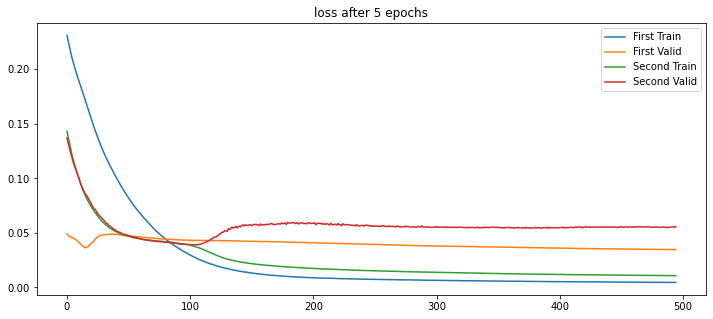

In [90]:
epochs = 500
tf.keras.backend.clear_session()
rrc_model,rrc_history =get_r_model(rrc_tensor_train,rrc_tensor_valid,epochs = epochs)
tf.keras.backend.clear_session()
rrt_model,rrt_history =get_r_model(rrt_tensor_train,rrt_tensor_valid,epochs =epochs)
plot_loss(rrc_history,rrt_history)

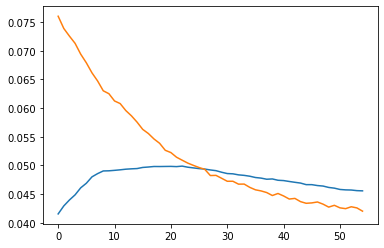

In [64]:
plt.plot(rrc_history.history['val_loss'][25:])
plt.plot(rrt_history.history['val_loss'][25:])

In [105]:
# get test data
df_poor_test = df_poor_train[-WINDOW_SIZE:]
df_rich_test = df_rich_train[-WINDOW_SIZE:]
px_test = px_scaler.transform(df_poor_test.values)
rx_test = rx_scaler.transform(df_rich_test.values)

In [106]:
pp_pred = pp_scaler.inverse_transform(pp_model.predict(px_test[np.newaxis,...])).reshape(30,)
prc_pred = prc_scaler.inverse_transform(prc_model.predict(px_test[np.newaxis,...])).reshape(30,)
prt_pred = prt_scaler.inverse_transform(prt_model.predict(px_test[np.newaxis,...])).reshape(30,)
rp_pred = rp_scaler.inverse_transform(rp_model.predict(rx_test[np.newaxis,...])).reshape(30,)
rrc_pred = rrc_scaler.inverse_transform(rrc_model.predict(rx_test[np.newaxis,...])).reshape(30,)
rrt_pred = rrt_scaler.inverse_transform(rrt_model.predict(rx_test[np.newaxis,...])).reshape(30,)

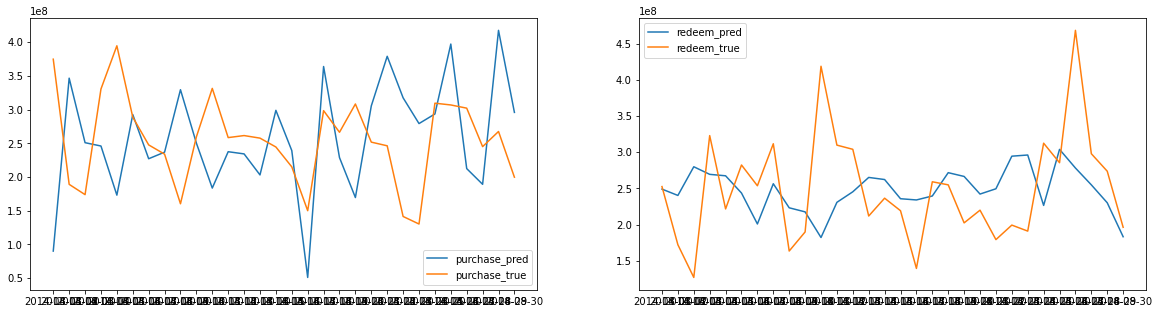

72.30491712380767

In [67]:
purchase_pred = pp_pred + rp_pred
redeem_pred = rrc_pred + rrt_pred + prt_pred + prc_pred
plot_test(purchase_pred,purchase_true,redeem_pred,redeem_true)
total_score(purchase_pred,purchase_true,redeem_pred,redeem_true)